In [107]:
import yfinance as yf
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.optimize import minimize

# 1. Data Importation

In [186]:
tickers = ['AAPL', 'XOM', 'JNJ', 'TSLA', 'F', 'MSFT']
'''tickers = ['AAPL', 'XOM', 'JNJ', 'TSLA', 'F', 'MSFT', 'CVX', 'PFE']'''
n = len(tickers)
start_date = "2020-01-01"
end_date = "2025-01-01"

data = yf.download(tickers, start="2020-01-01", end="2025-01-01")

/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_97653/3247737581.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  6 of 6 completed


In [187]:
data = data['Close']

In [188]:
print(data.head())

Ticker           AAPL         F         JNJ        MSFT       TSLA        XOM
Date                                                                         
2020-01-02  72.620819  7.204662  124.983688  153.042252  28.684000  54.634781
2020-01-03  71.914818  7.044048  123.536636  151.136627  29.534000  54.195564
2020-01-06  72.487846  7.005808  123.382568  151.527328  30.102667  54.611679
2020-01-07  72.146942  7.074642  124.136017  150.145752  31.270666  54.164722
2020-01-08  73.307503  7.074642  124.118896  152.537308  32.809334  53.347900


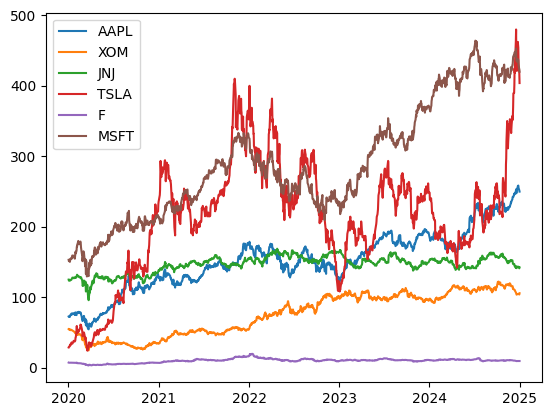

In [189]:
for ticker in tickers :
    plt.plot(data[ticker], label=ticker)

plt.legend()
plt.show()

In [190]:
log_returns = (data / data.shift(1)).apply(lambda x: np.log(x)).dropna()

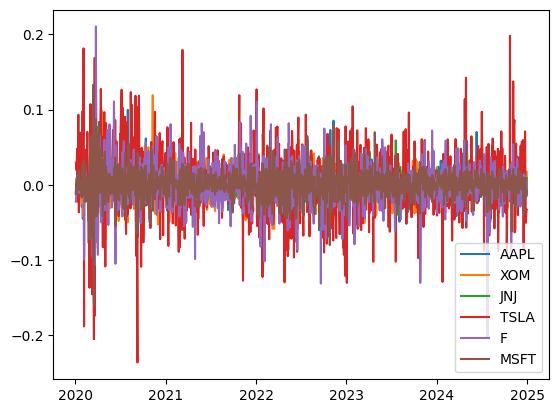

In [191]:
for ticker in tickers :
    plt.plot(log_returns[ticker], label=ticker)

plt.legend()
plt.show()

In [192]:
mean_returns = log_returns.mean() * 252  

cov_matrix = log_returns.cov() * 252

In [193]:
print(f'Mean returns : {mean_returns}')
print(f'Covariance matrix : {cov_matrix}')

Mean returns : Ticker
AAPL    0.247685
F       0.054362
JNJ     0.025945
MSFT    0.202335
TSLA    0.530198
XOM     0.132194
dtype: float64
Covariance matrix : Ticker      AAPL         F       JNJ      MSFT      TSLA       XOM
Ticker                                                            
AAPL    0.100198  0.051582  0.023279  0.072552  0.104444  0.031365
F       0.051582  0.198303  0.020962  0.048478  0.102349  0.068677
JNJ     0.023279  0.020962  0.038475  0.022568  0.011320  0.020327
MSFT    0.072552  0.048478  0.022568  0.093167  0.093272  0.026093
TSLA    0.104444  0.102349  0.011320  0.093272  0.448889  0.035068
XOM     0.031365  0.068677  0.020327  0.026093  0.035068  0.118258


# 2. Portfolio Simulation

In [194]:
m = 100000 # nombre de portefeuilles simulés
rf = 0.03 # risk free rate of return

In [195]:
randoms = np.random.rand(m,n)
weights = randoms / randoms.sum(axis=1, keepdims=True)

In [196]:
weights

array([[0.17764755, 0.03597671, 0.23178151, 0.29218176, 0.18148655,
        0.08092591],
       [0.12203127, 0.15454608, 0.30065411, 0.22564121, 0.01313887,
        0.18398847],
       [0.03962462, 0.22345146, 0.03023554, 0.14213499, 0.27466731,
        0.28988608],
       ...,
       [0.15706327, 0.07416404, 0.19171023, 0.23786009, 0.23273734,
        0.10646502],
       [0.18218855, 0.35596806, 0.04622511, 0.21048486, 0.09869368,
        0.10643974],
       [0.33145331, 0.01665341, 0.20715806, 0.09513796, 0.23625812,
        0.11333915]], shape=(100000, 6))

In [197]:
mu = []
sigma = []
sharpe_ratio = []

for i in range(weights.shape[0]):
    port_return = np.dot(weights[i], mean_returns)

    port_vol = np.sqrt(np.dot(weights[i], np.dot(cov_matrix, weights[i])))

    mu.append(port_return)
    sigma.append(port_vol)
    
    sharpe_ratio.append((port_return-rf)/port_vol)

In [198]:
portfolios = pd.DataFrame(data = {'Return':mu,'Volatility':sigma,'Sharpe Ratio':sharpe_ratio})

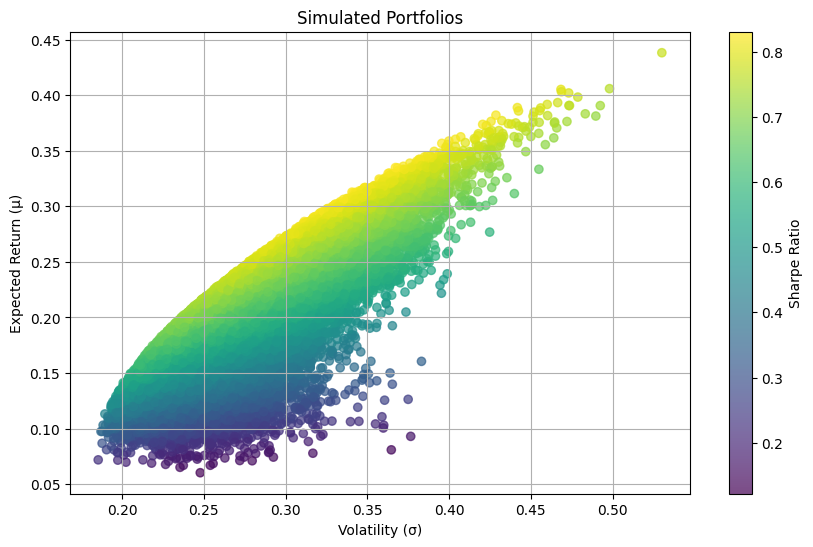

In [199]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    portfolios['Volatility'],
    portfolios['Return'],
    c=portfolios['Sharpe Ratio'],
    cmap='viridis',  
    alpha=0.7
)
plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Volatility (σ)')
plt.ylabel('Expected Return (μ)')
plt.title('Simulated Portfolios')
plt.grid(True)
plt.show()

# 3. Efficient Frontier

In [200]:
target_returns = np.linspace(portfolios['Return'].min(),portfolios['Return'].max(),100)

In [201]:
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights, np.dot(cov_matrix, weights))

def constraint_sum_to_one(weights):
    return np.sum(weights) - 1

def constraint_target_return(weights, mean_returns, target_return):
    return np.dot(weights, mean_returns) - target_return

x0 = np.ones(n) / n

bounds = tuple((0, 1) for _ in range(n))

weights = []
returns = []
vol = []

for i in range(len(target_returns)):
    constraints = [
        {'type': 'eq', 'fun': constraint_sum_to_one},
        {'type': 'eq', 'fun': constraint_target_return, 'args': (mean_returns, target_returns[i])}
    ]

    result = minimize(
        fun=portfolio_variance,
        x0=x0,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    opt_weights = result.x

    weights.append(opt_weights)
    returns.append(np.dot(opt_weights, mean_returns))
    vol.append(np.sqrt(portfolio_variance(opt_weights, cov_matrix)))

efficient_frontier = pd.DataFrame(data = {'weights':weights, 'returns':returns, 'volatility':vol})

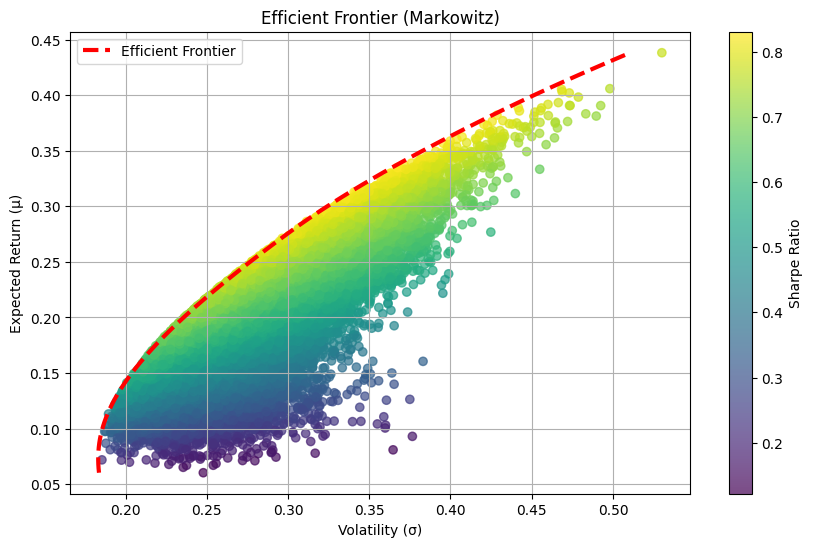

In [202]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    portfolios['Volatility'],
    portfolios['Return'],
    c=portfolios['Sharpe Ratio'],
    cmap='viridis',  
    alpha=0.7
)
plt.plot(efficient_frontier['volatility'], efficient_frontier['returns'], 'r--', linewidth=3, label='Efficient Frontier')
plt.xlabel('Volatility (σ)')
plt.ylabel('Expected Return (μ)')
plt.title('Efficient Frontier (Markowitz)')
plt.colorbar(scatter, label='Sharpe Ratio')
plt.grid(True)
plt.legend()
plt.show()

# 4. Minimal Variance Portfolio

In [203]:
constraints = [
    {'type': 'eq', 'fun': constraint_sum_to_one},
]

result = minimize(
    fun=portfolio_variance,
    x0=x0,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

min_var_weights = result.x
min_var_return = np.dot(min_var_weights,mean_returns)
min_vol = np.sqrt(np.dot(min_var_weights,np.dot(cov_matrix,min_var_weights)))

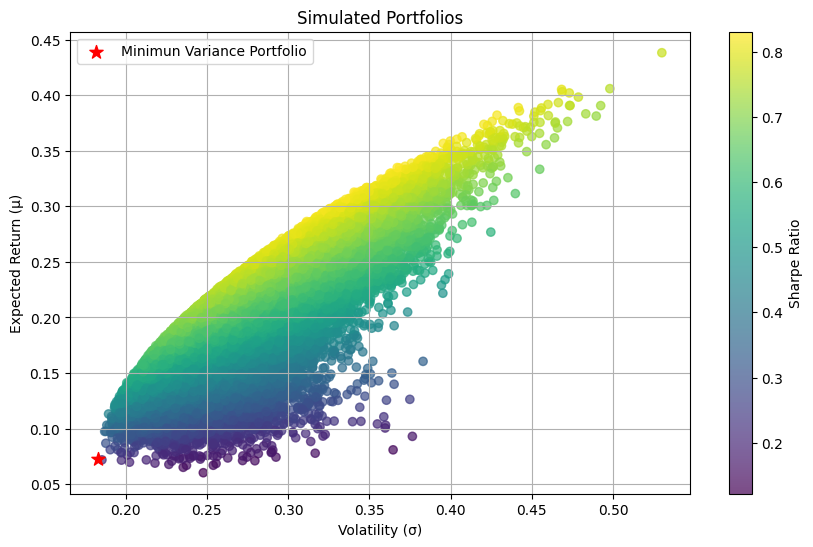

In [204]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    portfolios['Volatility'],
    portfolios['Return'],
    c=portfolios['Sharpe Ratio'],
    cmap='viridis',  
    alpha=0.7
)
plt.scatter(min_vol,min_var_return, label='Minimun Variance Portfolio', c='red', marker='*', s=100)
plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Volatility (σ)')
plt.ylabel('Expected Return (μ)')
plt.title('Simulated Portfolios')
plt.grid(True)
plt.legend()
plt.show()

# 5. Tangent Portfolio

In [205]:
import numpy as np
from scipy.optimize import minimize

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights, np.dot(cov_matrix, weights))

def constraint_sum_to_one(weights):
    return np.sum(weights) - 1

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(portfolio_variance(weights, cov_matrix))
    return -(port_return - rf) / port_vol

x0 = np.ones(n) / n
bounds = tuple((0, 1) for _ in range(n))

constraints = [{'type': 'eq', 'fun': constraint_sum_to_one}]

result = minimize(
    fun=neg_sharpe_ratio,
    x0=x0,
    args=(mean_returns, cov_matrix, rf),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

opt_weights = result.x
opt_return = np.dot(opt_weights, mean_returns)
opt_vol = np.sqrt(portfolio_variance(opt_weights, cov_matrix))
opt_sharpe = (opt_return - rf) / opt_vol


print("Tangent Portfolio:")
print("Weights:", opt_weights)
print("Return:", opt_return)
print("Volatility:", opt_vol)
print("Sharpe Ratio:", opt_sharpe)

Tangent Portfolio:
Weights: [5.30521998e-01 0.00000000e+00 1.40826134e-16 2.77001927e-16
 3.42609059e-01 1.26868943e-01]
Return: 0.3298246439973349
Volatility: 0.3578184868526793
Sharpe Ratio: 0.8379238496997456


# 6. Final Representation

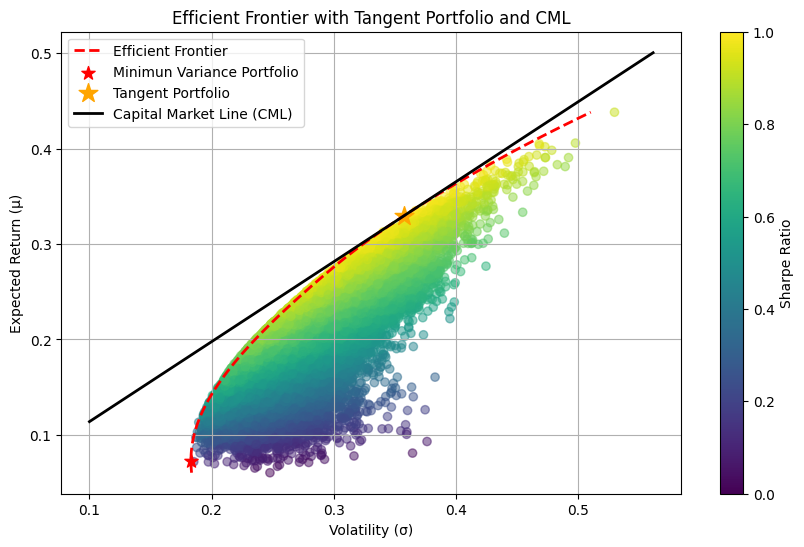

In [206]:

cml_vol = np.linspace(0.1, max(efficient_frontier['volatility']) * 1.1, 100)
cml_return = rf + opt_sharpe * cml_vol 

plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Volatility'], portfolios['Return'], c=portfolios['Sharpe Ratio'], cmap='viridis', alpha=0.5)

plt.plot(efficient_frontier['volatility'], efficient_frontier['returns'], 'r--', linewidth=2, label='Efficient Frontier')

plt.scatter(min_vol,min_var_return, label='Minimun Variance Portfolio', c='red', marker='*', s=100)

plt.scatter(opt_vol, opt_return, color='orange', marker='*', s=200, label='Tangent Portfolio')

plt.plot(cml_vol, cml_return, 'k-', linewidth=2, label='Capital Market Line (CML)')

plt.xlabel('Volatility (σ)')
plt.ylabel('Expected Return (μ)')
plt.title('Efficient Frontier with Tangent Portfolio and CML')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.legend()
plt.show()
